# ARIMA MODEL

In [58]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
# Import dataset
location_holidays = "C:\\Users\\75558\\OneDrive - Bain\\Documents\\KAGGLE\\Sales project\\holidays_events.csv"
holidays = pd.read_csv(location_holidays, parse_dates=['date'])
location_oil = "C:\\Users\\75558\\OneDrive - Bain\\Documents\\KAGGLE\\Sales project\\oil.csv"
oil = pd.read_csv(location_oil, parse_dates=['date'])
location_stores = "C:\\Users\\75558\\OneDrive - Bain\\Documents\\KAGGLE\\Sales project\\stores.csv"
stores = pd.read_csv(location_stores)
location_transactions = "C:\\Users\\75558\\OneDrive - Bain\\Documents\\KAGGLE\\Sales project\\transactions.csv"
transactions = pd.read_csv(location_transactions, parse_dates=['date'])
location_train = "C:\\Users\\75558\\OneDrive - Bain\\Documents\\KAGGLE\\Sales project\\train.csv"
train = pd.read_csv(location_train, parse_dates=['date'])
location_test = "C:\\Users\\75558\\OneDrive - Bain\\Documents\\KAGGLE\\Sales project\\test.csv"
test = pd.read_csv(location_test, parse_dates=['date'])


In [60]:
#Train 80% and test 20% split
train_size = int(len(train)*0.8)
train, train_20 = train[:train_size], train[train_size:]

In [61]:
#Plot sales over time with trend
plt.figure(figsize=(12,6))
sales_perday = train[(train['date'] >= '2012-01-01') & (train['date'] < '2017-12-30')]
sales_perday = sales_perday.groupby('date').agg({'sales': 'sum'}).reset_index()
sales_perday_train20 = train_20[(train_20['date'] >= '2012-01-01') & (train_20['date'] < '2017-12-30')]
sales_perday_train20 = sales_perday_train20.groupby('date').agg({'sales': 'sum'}).reset_index()
sns.lineplot(data=sales_perday, x='date', y = 'sales')
sns.lineplot(data=sales_perday_train20, x='date', y = 'sales', color='red')
sns.lineplot(x=sales_perday['date'],y=sales_perday['sales'].rolling(window=30).mean(),color='black')



KeyboardInterrupt: 

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='date', ylabel='sales'>

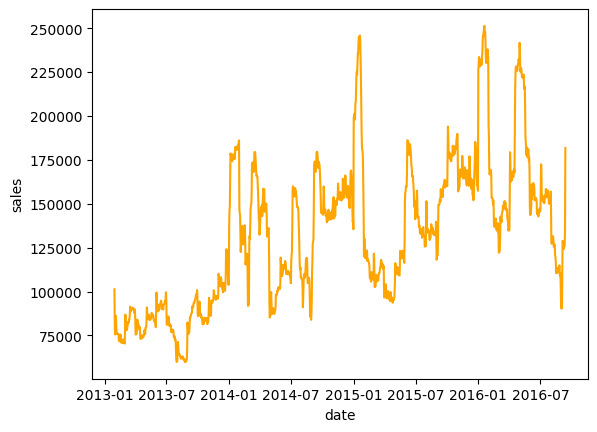

In [ ]:
#Variance behaviour
sns.lineplot(x=sales_perday['date'],y=sales_perday['sales'].rolling(window=30).std(),color='orange')

In [ ]:
#Stabilize variance with box-cox tranformation
from scipy.stats import boxcox
#sales_perday['sales_boxcox'], lambda_value = boxcox(sales_perday['sales'])
#sales_perday_train20['sales_boxcox'] = sales_perday_train20['sales'].apply(lambda x: boxcox(x, lmbda=lambda_value))
#sns.lineplot(x=sales_perday['date'],y=sales_perday['sales_boxcox'].rolling(window=30).std(),color='orange')
sales_perday['sales_boxcox'] = sales_perday['sales']
sales_perday_train20['sales_boxcox'] = sales_perday_train20['sales']

In [ ]:
#Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(sales_perday['sales_boxcox'])
print('ADF Statistic:', result[0])
print('p-value: ',result[1])


ADF Statistic: -2.75107922501812
p-value:  0.06560865770879078


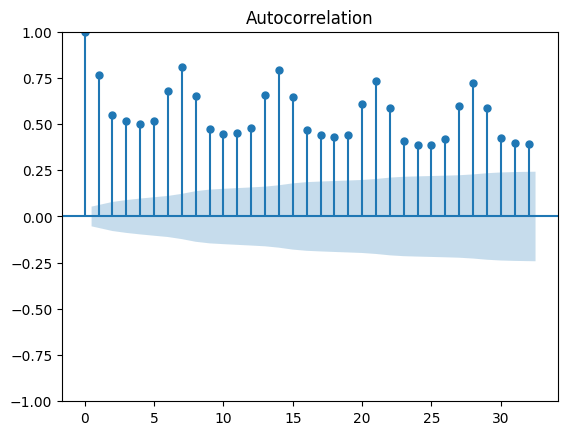

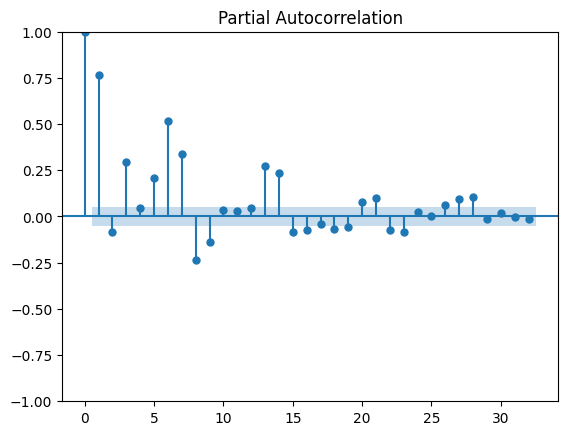

In [ ]:
#ARIMA model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
plot_acf(sales_perday['sales_boxcox'])
plot_pacf(sales_perday['sales_boxcox'])
plt.show()

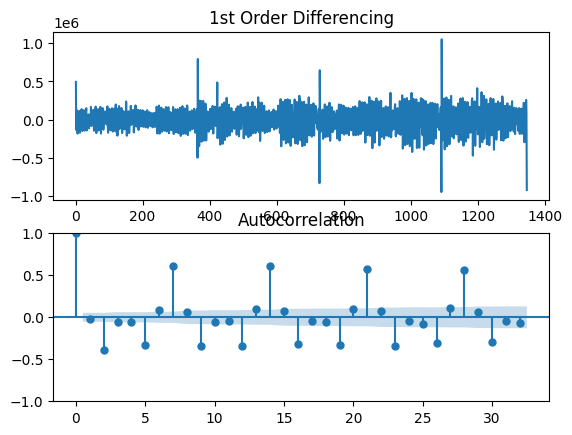

In [ ]:
#Differencing the series
f=plt.figure()
ax1=f.add_subplot(211)
ax1.set_title('1st Order Differencing')
ax1.plot(sales_perday['sales_boxcox'].diff())

ax2=f.add_subplot(212)
plot_acf(sales_perday['sales_boxcox'].diff().dropna(),ax=ax2)

plt.show()


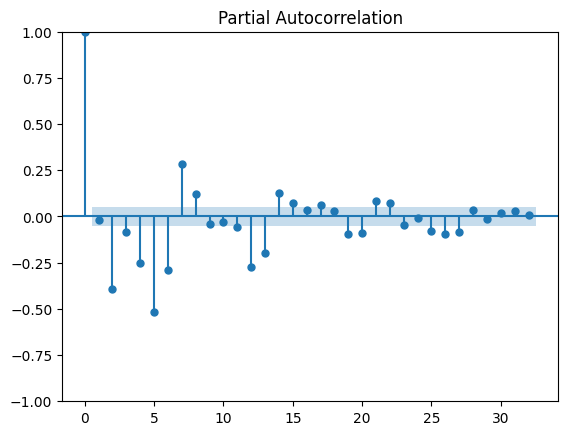

In [ ]:
plot_pacf(sales_perday['sales_boxcox'].diff().dropna())
plt.show()

In [ ]:
result=adfuller(sales_perday['sales_boxcox'].diff().dropna())
print('P-Value dif1:', result[1])
result=adfuller(sales_perday['sales_boxcox'].diff().diff().dropna())
print('P-Value dif2:', result[1])

P-Value dif1: 1.28752185467002e-14
P-Value dif2: 1.9115208360146675e-28


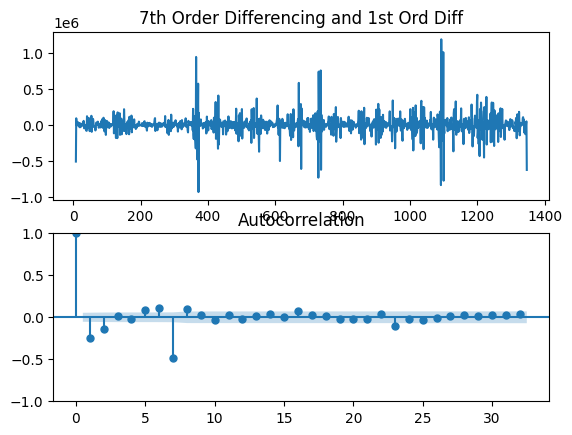

In [ ]:
#Differencing order 7
f=plt.figure()
ax1=f.add_subplot(211)
ax1.set_title('7th Order Differencing and 1st Ord Diff')
ax1.plot(sales_perday['sales_boxcox'].diff(1).diff(7))
ax2=f.add_subplot(212)
plot_acf(sales_perday['sales_boxcox'].diff(1).diff(7).dropna(),ax=ax2)
plt.show()

<Axes: xlabel='date', ylabel='sales_boxcox'>

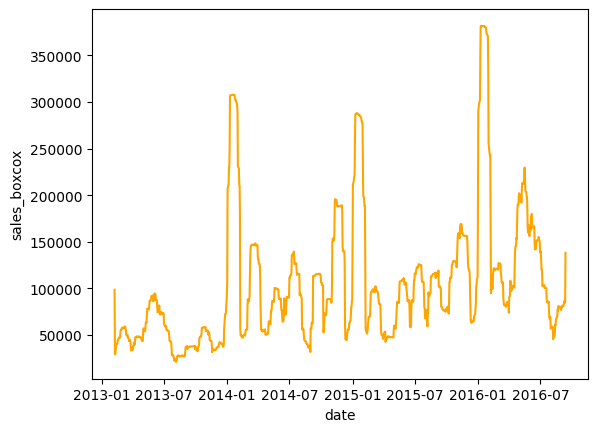

In [ ]:
#Variance behaviour after differencing
sns.lineplot(x=sales_perday['date'],y=sales_perday['sales_boxcox'].diff(7).diff().rolling(window=30).std(),color='orange')


In [ ]:
#ARIMA (p=7,d=1,q=2)
model = ARIMA(sales_perday['sales_boxcox'], order=(7, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           sales_boxcox   No. Observations:                 1348
Model:                 ARIMA(7, 1, 2)   Log Likelihood              -17401.618
Date:                Fri, 22 Aug 2025   AIC                          34823.237
Time:                        13:32:24   BIC                          34875.293
Sample:                             0   HQIC                         34842.734
                               - 1348                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1157      0.070     -1.655      0.098      -0.253       0.021
ar.L2         -0.5363      0.073     -7.301      0.000      -0.680      -0.392
ar.L3         -0.2580      0.055     -4.657      0.0

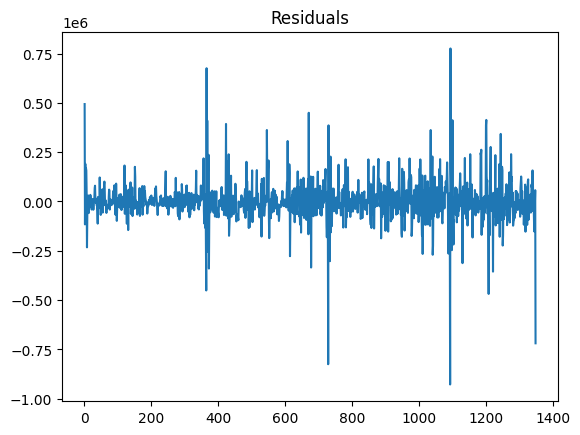

In [ ]:
residuals = model_fit.resid[1:]
residuals.plot(title='Residuals')
#residuals.plot(title='Density',kind='kde')
plt.show()

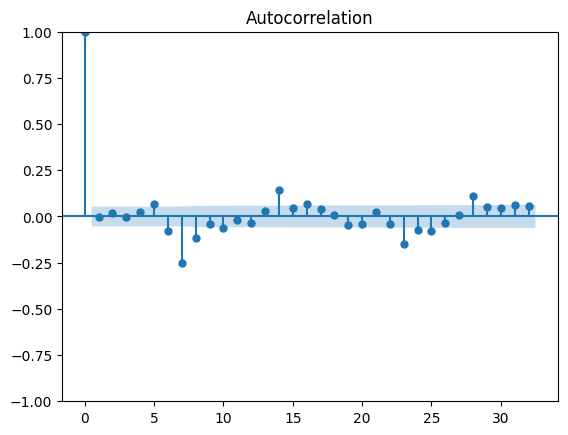

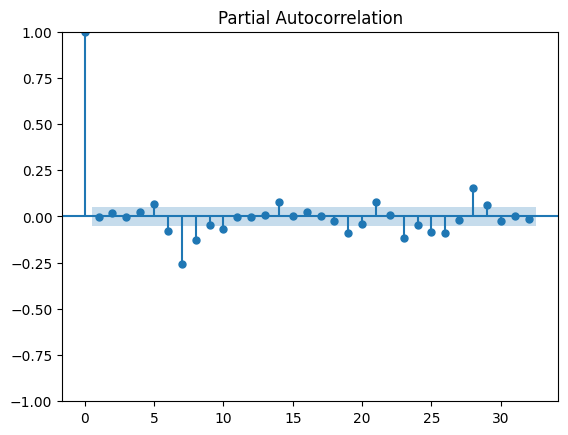

In [ ]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)
plt.show()

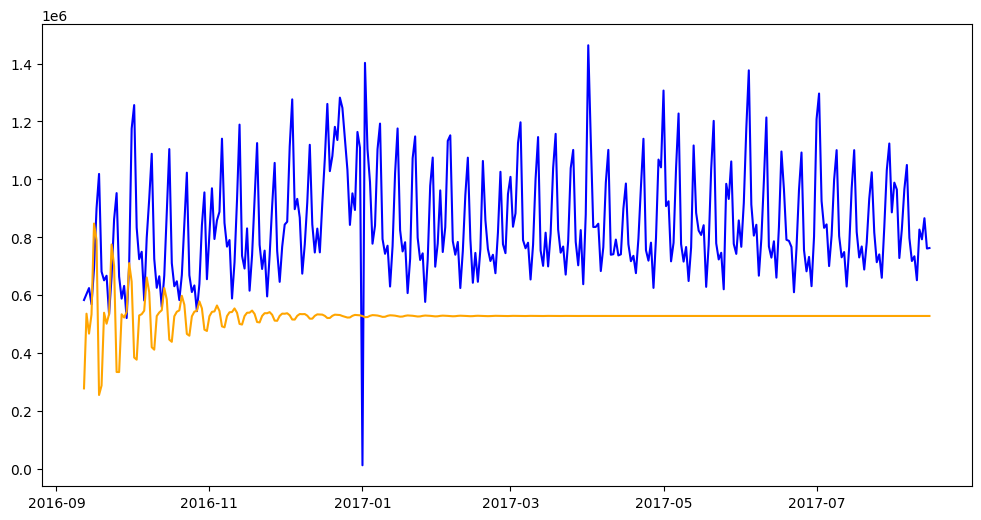

In [ ]:
# Forecasting with ARIMA sales_perday_train20
forecast_train = model_fit.forecast(steps=len(sales_perday_train20))
plt.figure(figsize=(12,6))
plt.plot(sales_perday_train20['date'], sales_perday_train20['sales_boxcox'], label='Actual Sales', color='blue')
plt.plot(sales_perday_train20['date'], forecast_train, label='Forecasted Sales', color='orange')
plt.show()



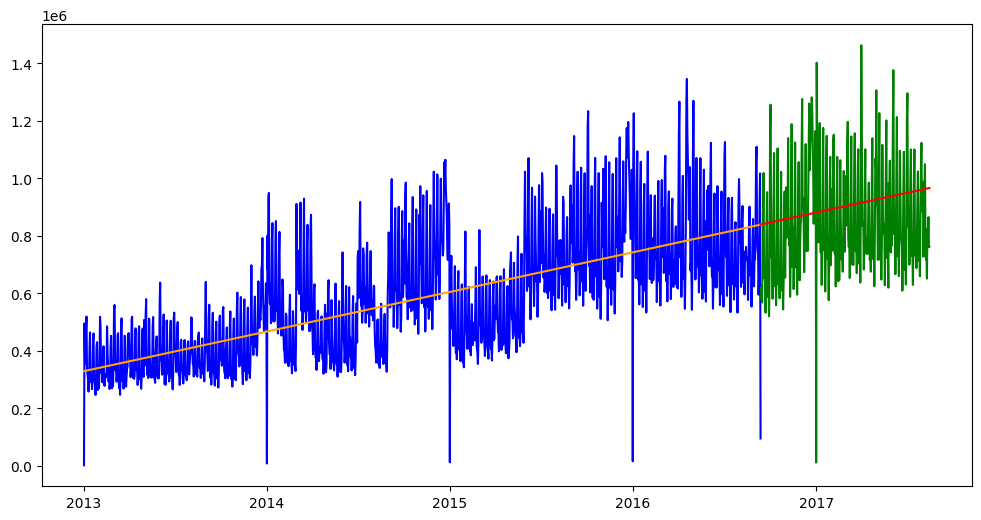

In [ ]:
#Use linear regression to learn the trend
from sklearn.linear_model import LinearRegression
#Fit trend model
X_train = np.arange(len(sales_perday)).reshape(-1, 1)
Y_train = sales_perday['sales_boxcox'].values
model_LR = LinearRegression()
model_LR.fit(X_train, Y_train)
#Plot trend line
plt.figure(figsize=(12,6))
plt.plot(sales_perday['date'], sales_perday['sales_boxcox'], label='Actual Sales', color='blue')
plt.plot(sales_perday['date'], model_LR.predict(X_train), label='Trend Line', color='orange')
#Forecasting with Linear Regression
forecast_train_20 = model_LR.predict(np.arange(len(sales_perday), len(sales_perday) + len(sales_perday_train20)).reshape(-1, 1))
plt.plot(sales_perday_train20['date'], sales_perday_train20['sales_boxcox'], label='Actual Sales', color='green')
plt.plot(sales_perday_train20['date'], forecast_train_20, label='Forecasted Sales', color='red')
plt.show()


In [ ]:
#NEXT STEPS
#SEE THE ANSWER IN KAGGLE